In [5]:
import numpy as np
import pandas as pd
from statsmodels.stats.proportion import proportion_confint

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import linear_model

2022-05-02 21:05:46.310705: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-02 21:05:46.310747: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [6]:
plt.style.use('seaborn')

In [7]:
data = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-04-20/netflix_titles.csv')

In [8]:
data.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [5]:
data.date_added = pd.to_datetime(data.date_added)
data['year_added'] = data.date_added.dt.year

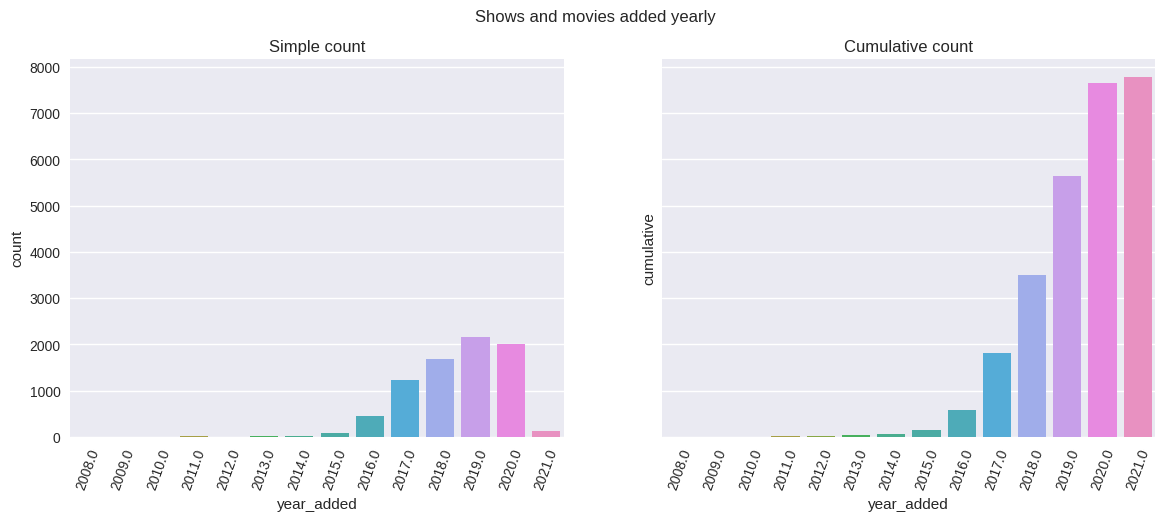

In [6]:
data_year = data.groupby('year_added', as_index=False).count()[['year_added','type']].sort_values('year_added')
data_year['cumulative'] = data_year.type.cumsum()
data_year = data_year.rename(columns={'type':'count'})

fig, ax = plt.subplots(1,2, figsize=(14,5), dpi=100, sharey=True)
sns.barplot(data=data_year, x='year_added',y='count', ax=ax[0])
sns.barplot(data=data_year, x='year_added',y='cumulative', ax=ax[1])
ax[0].tick_params(rotation=70, axis='x')
ax[1].tick_params(rotation=70, axis='x')
fig.suptitle('Shows and movies added yearly')
ax[0].set_title('Simple count')
ax[1].set_title('Cumulative count')

plt.show()

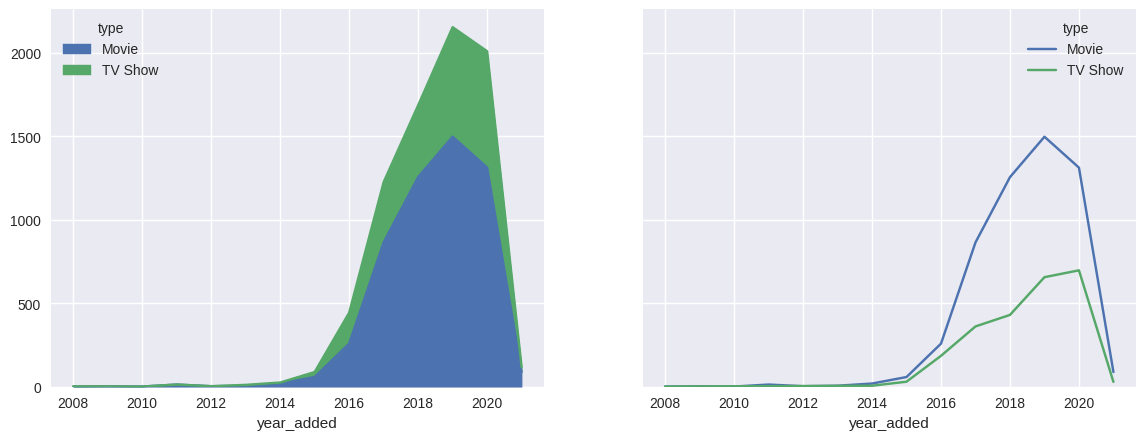

In [7]:
data_year_type = data.groupby(['year_added','type'], as_index=False).count()[['year_added','type','show_id']].sort_values('year_added')
data_year_type = data_year_type.rename(columns={'show_id':'count'})
data_year_type_pivot = data_year_type.pivot(values='count', index='year_added',columns='type')

fig, ax = plt.subplots(1,2,figsize=(14,5),dpi=100, sharey=True)
sns.lineplot(data=data_year_type,x='year_added',y='count',hue='type', ax=ax[1])
data_year_type_pivot.plot.area(ax=ax[0])
plt.show()

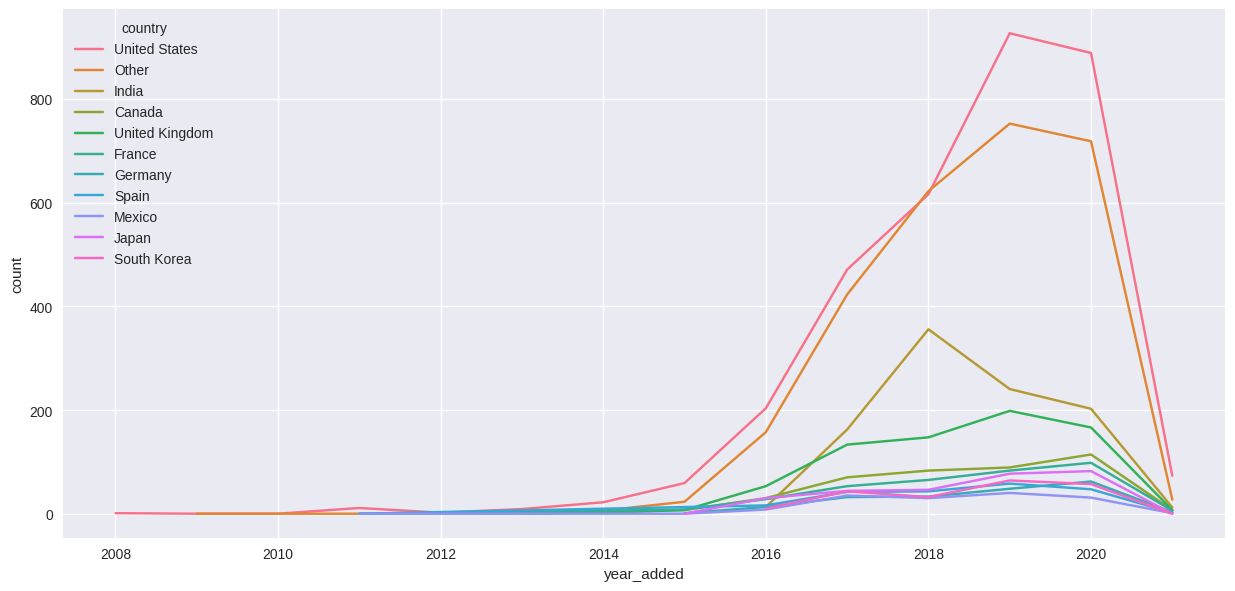

In [8]:
data_year_country = data.copy()
data_year_country['country'] = data_year_country.country.str.split(',')
data_year_country = data_year_country.explode('country')
data_year_country['country'] = data_year_country.country.str.strip()
f = data_year_country.groupby('country').count()['show_id'].sort_values(ascending=False)[:10].index.tolist()

data_year_country.loc[data_year_country['country'].isin(f)==False, 'country'] = 'Other'
data_year_country = data_year_country.groupby(['year_added','country'], as_index=False).count()[['year_added','country','show_id']] \
                    .sort_values(['year_added','show_id'], ascending=False)
data_year_country = data_year_country.rename(columns={'show_id':'count'})

plt.figure(figsize=(15,7),dpi=100)
sns.lineplot(data=data_year_country,x='year_added',y='count',hue='country')
plt.show()

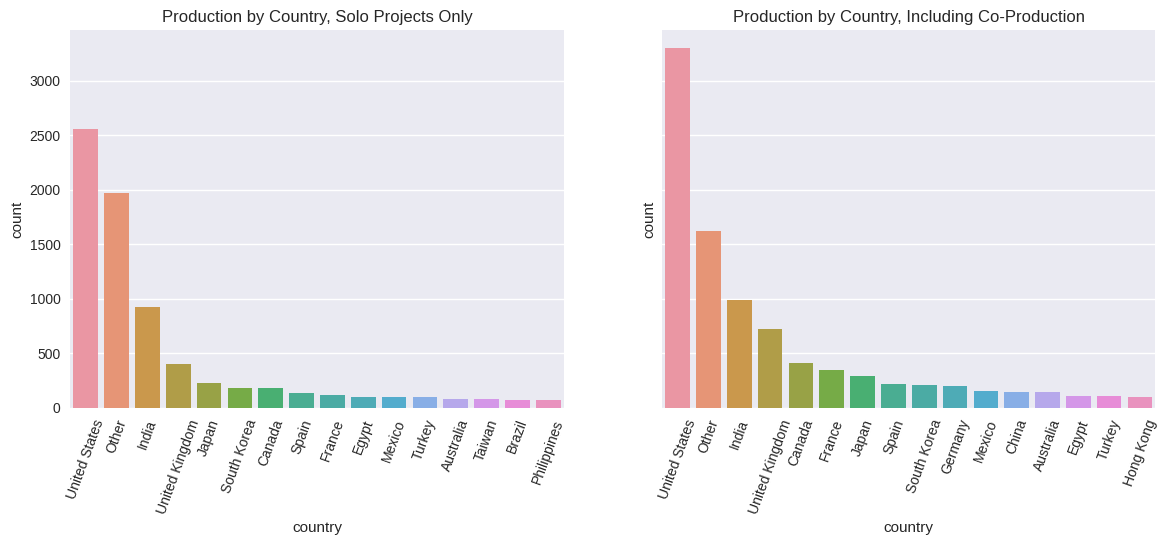

In [9]:
data_country_contrib = data.copy()
data_country_contrib['country'] = data_country_contrib.country.str.split(',')
data_country_contrib = data_country_contrib.explode('country')
data_country_contrib['country'] = data_country_contrib.country.str.strip()
data_country_contrib = data_country_contrib.groupby('country', as_index=False).count()[['country','show_id']].sort_values(by='show_id',ascending=False)
data_country_contrib = data_country_contrib.rename(columns={'show_id':'count'})
f_contrib = data_country_contrib.country[:15]
data_country_contrib.loc[data_country_contrib.country.isin(f_contrib)==False,'country'] = 'Other'
data_country_contrib = data_country_contrib.groupby('country', as_index=False).sum().sort_values('count', ascending=False)


data_country = data.copy()
data_country = data_country.groupby('country', as_index=False).count()[['country','show_id']].sort_values(by='show_id',ascending=False)
data_country = data_country.rename(columns={'show_id':'count'})
f = data_country.country[:15]
data_country.loc[data_country.country.isin(f)==False,'country'] = 'Other'
data_country = data_country.groupby('country', as_index=False).sum().sort_values('count', ascending=False)

fig, ax = plt.subplots(1,2, figsize=(14,5), dpi=100, sharey=True)
sns.barplot(data=data_country, y='count', x='country', orient='v', ax=ax[0])
sns.barplot(data=data_country_contrib, y='count', x='country', orient='v', ax=ax[1])
ax[0].tick_params(rotation=70, axis='x')
ax[1].tick_params(rotation=70, axis='x')
ax[0].set_title('Production by Country, Solo Projects Only')
ax[1].set_title('Production by Country, Including Co-Production')
plt.show()

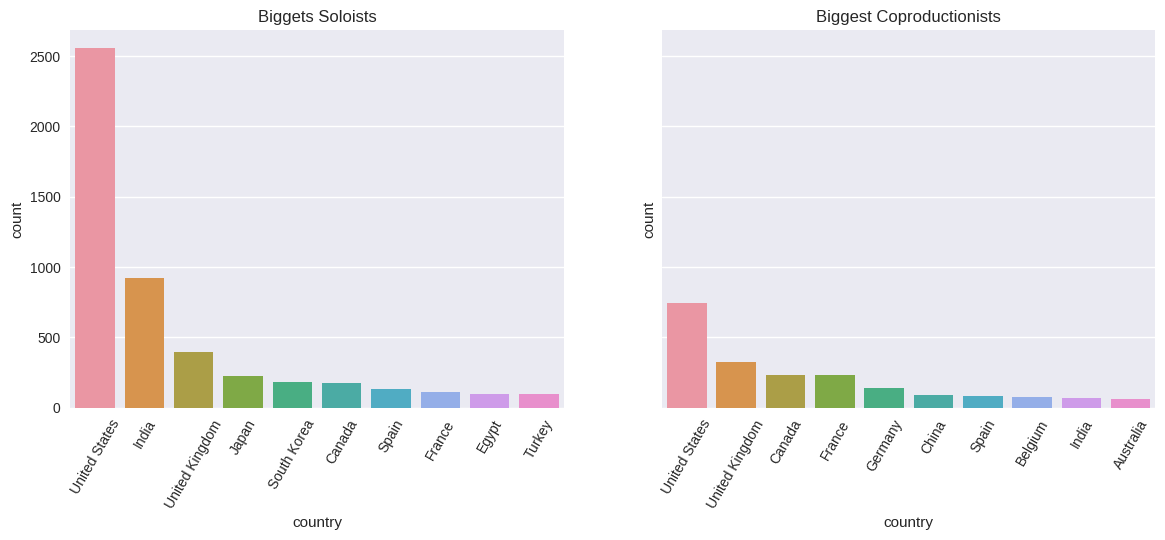

In [10]:
copros = data.copy()
copros['country'] = copros.country.str.split(',')
copros = copros.explode('country')
copros['country'] = copros.country.str.strip()
copros = copros[copros['show_id'].duplicated(keep=False)]
copros = copros.groupby('country', as_index=False).count().sort_values('show_id', ascending=False)[['country','show_id']][:10]
copros = copros.rename(columns={'show_id':'count'})

solos = data.copy()
solos['country'] = solos.country.str.split(',')
solos = solos.explode('country')
solos['country'] = solos.country.str.strip()
solos = solos[~solos['show_id'].duplicated(keep=False)]
solos = solos.groupby('country', as_index=False).count().sort_values('show_id', ascending=False)[['country','show_id']][:10]
solos = solos.rename(columns={'show_id':'count'})

plt.style.use('seaborn')
fig,ax = plt.subplots(1,2, figsize=(14,5),dpi=100, sharey=True)
sns.barplot(data=solos, x='country', y='count', orient='v', ax=ax[0])
sns.barplot(data=copros, x='country', y='count', orient='v', ax=ax[1])
ax[0].set_title('Biggets Soloists')
ax[1].set_title('Biggest Coproductionists')
ax[0].tick_params(rotation=60, axis='x')
ax[1].tick_params(rotation=60, axis='x')
plt.show()

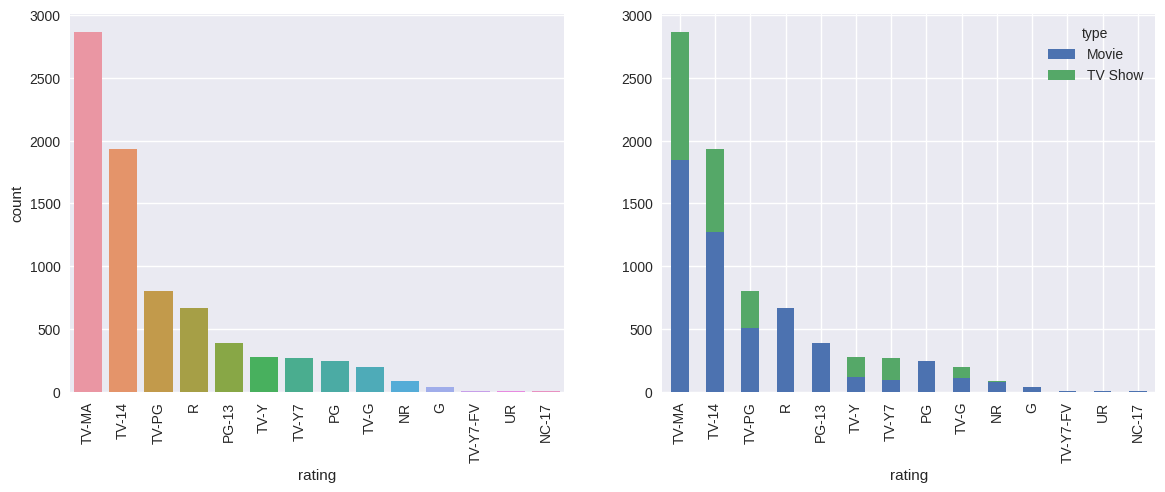

In [11]:
data_rating = data.copy()
data_rating = data_rating.groupby('rating', as_index=False).count()[['rating','show_id']].sort_values('show_id', ascending=False)
data_rating = data_rating.rename(columns={'show_id':'count'})

data_rating_type = data.copy()
data_rating_type = data_rating_type.groupby(['rating','type'], as_index=False).count()[['rating','type','show_id']].sort_values('show_id', ascending=False)
data_rating_type = data_rating_type.rename(columns={'show_id':'count'})
data_rating_type_pivot = data_rating_type.pivot(index='rating',columns='type',values='count').fillna(value=0)
data_rating_type_pivot['total'] = data_rating_type_pivot['Movie']+data_rating_type_pivot['TV Show']
data_rating_type_pivot = data_rating_type_pivot.sort_values('total',ascending=False).drop('total',axis=1)

fig,ax = plt.subplots(1,2,figsize=(14,5),dpi=100)
sns.barplot(data=data_rating,x='rating',y='count',ax=ax[0])
data_rating_type_pivot.plot.bar(stacked=True, ax=ax[1])
ax[0].tick_params(rotation=90, axis='x')
plt.show()

In [12]:
data_rating2 = data[['country','rating']].copy()
data_rating2['country'] = data_rating2['country'].str.split(',')
data_rating2 = data_rating2.explode('country')
data_rating2['country'] = data_rating2['country'].str.strip()
data_rating2.loc[data_rating2['rating'].isin(['TV-MA','R','NC-17']),'rating'] = 'adult'
data_rating2.loc[~data_rating2['rating'].isin(['adult']),'rating'] = 'other'
data_rating2 = data_rating2.groupby(['country','rating'],as_index=True).size().unstack(fill_value=0)
data_rating2['N'] = data_rating2['adult'] + data_rating2['other']
data_rating2['adult_proportion'] = data_rating2['adult']/data_rating2['N']
upper,lower = proportion_confint(data_rating2['adult'],data_rating2['N'])
data_rating2['upper'],data_rating2['lower'] = [upper,lower]
data_rating2 = data_rating2.sort_values('N', ascending=False)[:10]

data_rating3 = data[['country','rating']].copy()
data_rating3['country'] = data_rating3['country'].str.split(',')
data_rating3 = data_rating3.explode('country')
data_rating3['country'] = data_rating3['country'].str.strip()
data_rating3.loc[data_rating3['rating'].isin(['TV-MA','R','NC-17']),'rating'] = 1
data_rating3.loc[~data_rating3['rating'].isin([1]),'rating'] = 0
data_rating3 = data_rating3.dropna()
data_rating3 = data_rating3.loc[data_rating3.country.isin(data_rating2.index)]

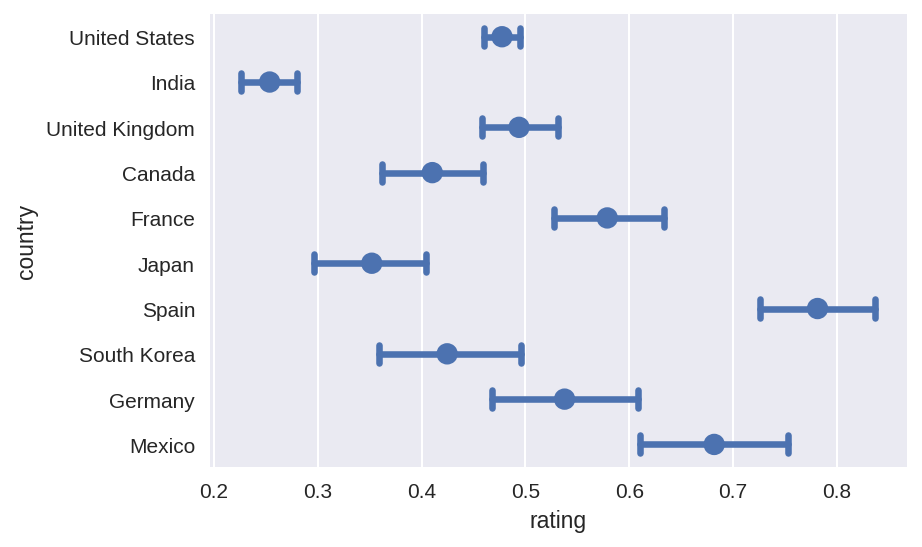

In [13]:
plt.figure(figsize=(6,4),dpi=150)
ax = sns.pointplot(data=data_rating3, x='rating',y='country', join=False, capsize=0.4, order=data_rating2.index,ci=95)
plt.show()

In [14]:
data_rating2

rating,adult,other,N,adult_proportion,upper,lower
country,,,,,,
United States,1574,1723,3297,0.477404,0.460354,0.494453
India,251,739,990,0.253535,0.226436,0.280634
United Kingdom,357,366,723,0.493776,0.457333,0.530219
Canada,169,243,412,0.410194,0.362699,0.457689
France,202,147,349,0.578797,0.526995,0.630598
Japan,101,186,287,0.351916,0.296665,0.407168
Spain,168,47,215,0.781395,0.726150,0.836640
South Korea,90,122,212,0.424528,0.357994,0.491063
Germany,107,92,199,0.537688,0.468417,0.606960


In [15]:
spacy.__version__

'2.2.4'

In [16]:
nlp = spacy.load('en_core_web_sm')

tokens_description = []
for doc in nlp.pipe(data['description']):
  tokens = [token.lower_ for token in doc if not 
                        (
                          token.is_stop
                          or token.is_punct
                          or token.is_space
                          or token.like_url
                          or token.like_email
                          or token.is_currency
                          or token.like_num
                         )]
  tokens_description.append(tokens)

In [17]:
data_tokens_description = data.copy()
data_tokens_description['tokens'] = tokens_description
data_tokens_description['genre'] = data_tokens_description['listed_in'].str.split(',')
data_tokens_description = data_tokens_description.explode('genre').explode('tokens')[['genre','tokens']]
data_tokens_description['genre'] = data_tokens_description['genre'].str.strip()
data_tokens_description = data_tokens_description.groupby(['genre','tokens']).size()
data_tokens_description = data_tokens_description.groupby('genre', group_keys=False).nlargest(10).reset_index().rename(columns={0:'size'})
# data_tokens_description = data_tokens_description.groupby('genre').apply(lambda x:x.sort_values(ascending=False)[:10])

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 800x550 with 0 Axes>

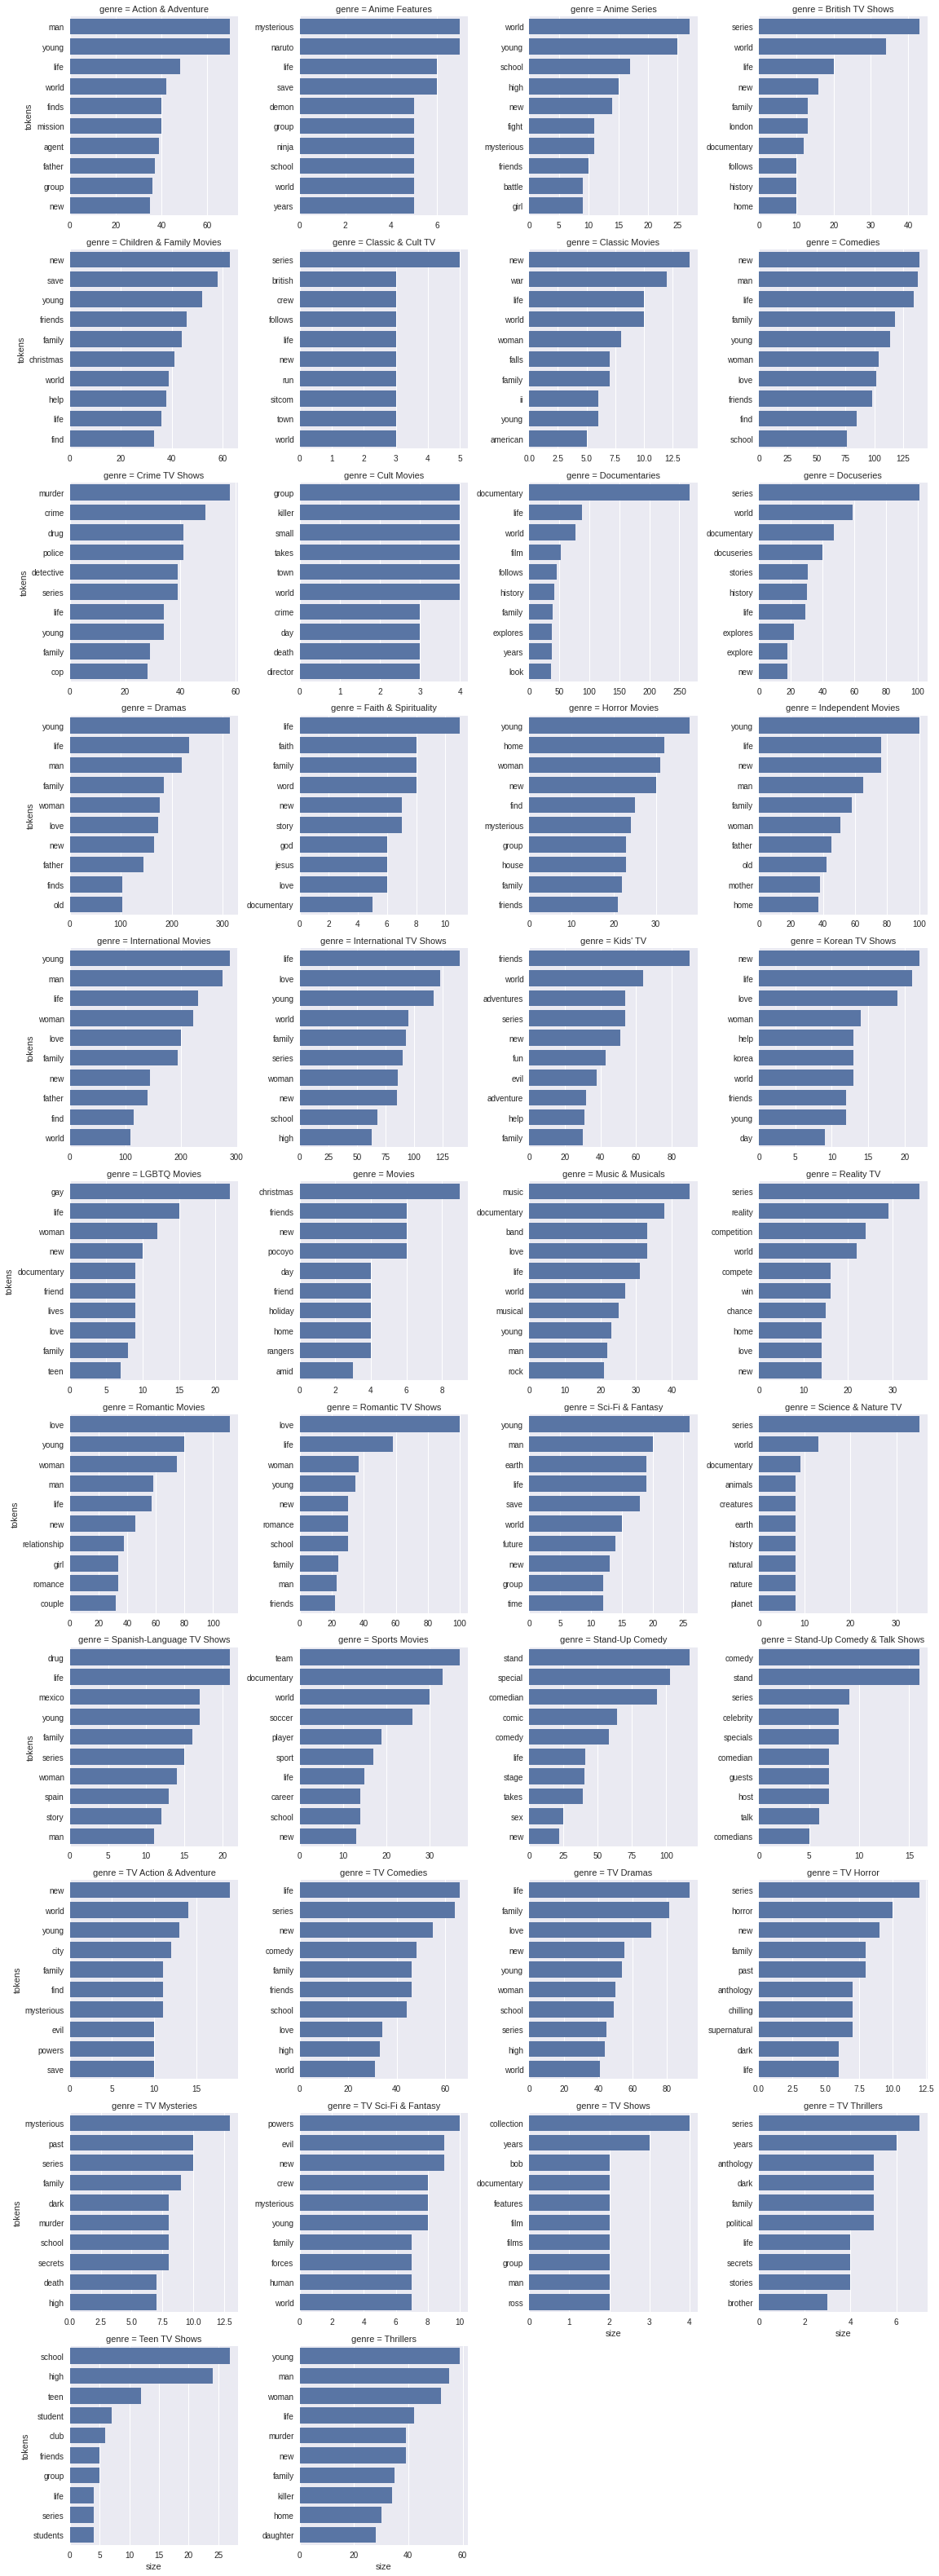

In [18]:
plt.figure(dpi=100)
g = sns.FacetGrid(data=data_tokens_description, col='genre', col_wrap=4, height=4, aspect=1, sharex=False, sharey=False)
g.map(sns.barplot,'size','tokens')
plt.show()

In [19]:
tokens_title = []

for doc in nlp.pipe(data['title']):
  tokens = [token.lower_ for token in doc if not
                          (
                          token.is_stop
                          or token.is_punct
                          or token.is_space
                          or token.like_url
                          or token.like_email
                          or token.is_currency
                          or token.like_num
                         )]
  tokens_title.append(tokens)

In [20]:
data_tokens_title = data.copy()
data_tokens_title['tokens'] = tokens_title
data_tokens_title['genre'] = data_tokens_title['listed_in'].str.split(',')
data_tokens_title = data_tokens_title.explode('genre').explode('tokens')[['genre','tokens']]
data_tokens_title['genre'] = data_tokens_title['genre'].str.strip()
data_tokens_title = data_tokens_title.groupby(['genre','tokens']).size()
data_tokens_title = data_tokens_title.groupby('genre', group_keys=False).nlargest(10).reset_index().rename(columns={0:'size'})

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 800x550 with 0 Axes>

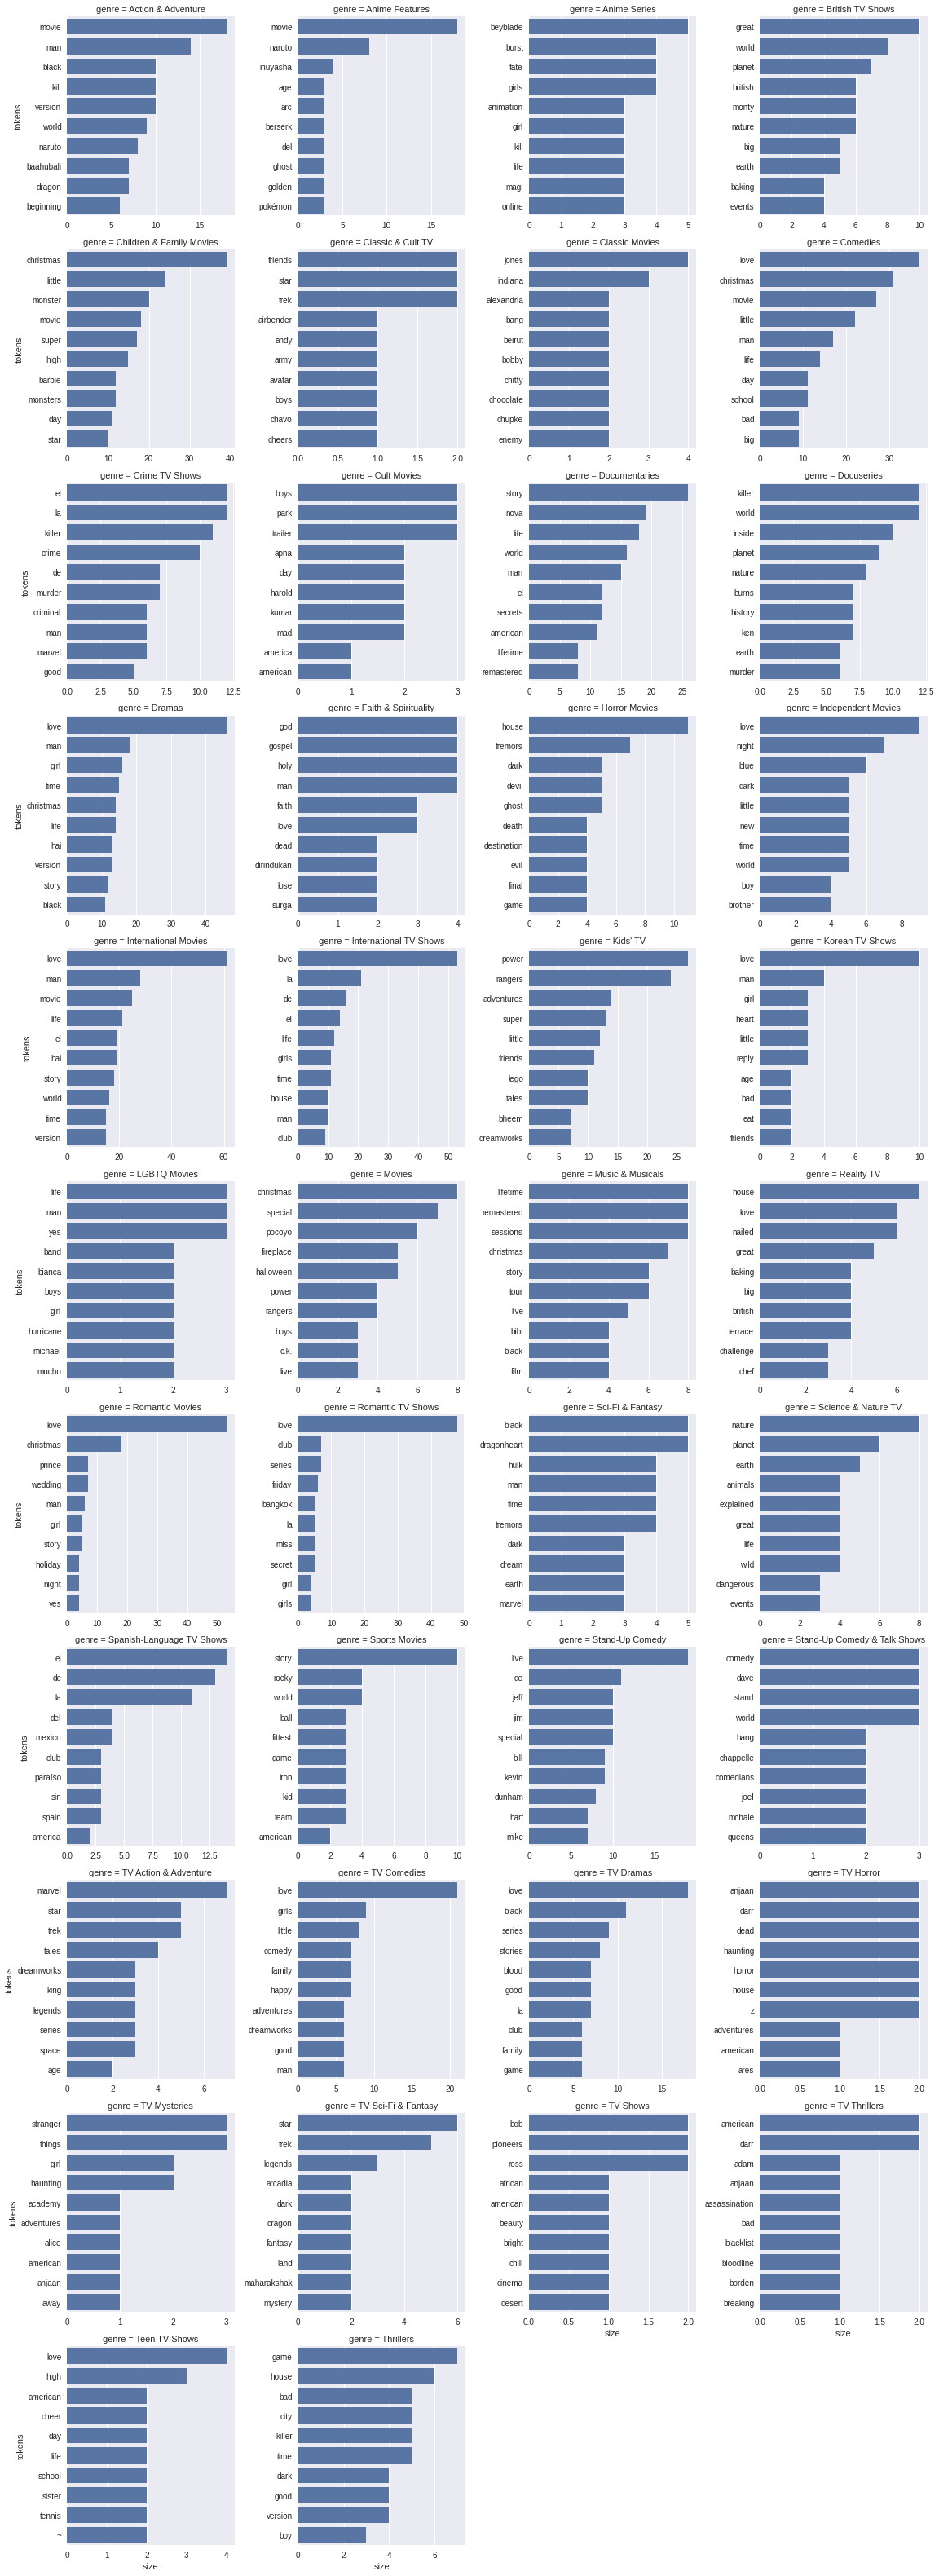

In [21]:
plt.figure(dpi=100)
g = sns.FacetGrid(data=data_tokens_title, col='genre', col_wrap=4, height=4, aspect=1, sharex=False, sharey=False)
g.map(sns.barplot,'size','tokens')
plt.show()

In [22]:
data_tokens_rating = data.copy()
data_tokens_rating['tokens'] = tokens_description
# data_tokens_rating.loc[data_tokens_rating['rating'].isin(['TV-MA','R','NC-17']),'rating'] = 'adult'
# data_tokens_rating.loc[~data_tokens_rating['rating'].isin(['adult']),'rating'] = 'other'
data_tokens_rating = data_tokens_rating.explode('tokens')[['rating','tokens']]
data_tokens_rating = data_tokens_rating.groupby(['rating','tokens']).size()
data_tokens_rating = data_tokens_rating.groupby('rating',group_keys=False).nlargest(10).reset_index().rename(columns={0:'size'})

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 1500x1500 with 0 Axes>

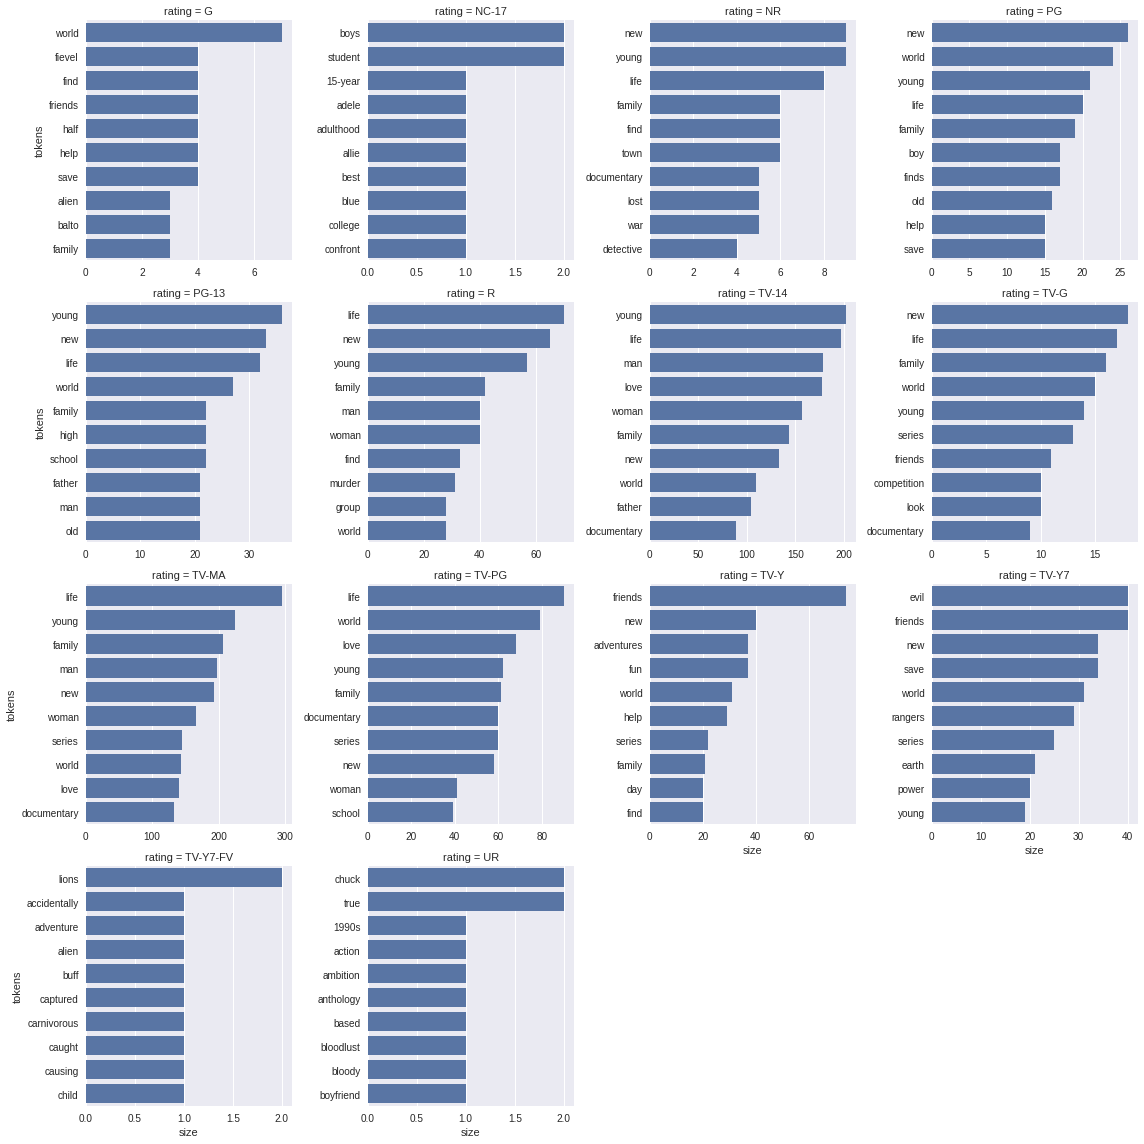

In [23]:
plt.figure(figsize=(5,5), dpi=300)
g = sns.FacetGrid(data=data_tokens_rating, col='rating', sharex=False, sharey=False, height=4, aspect=1, col_wrap=4)
g.map(sns.barplot,'size','tokens')
plt.show()

In [24]:
data_tokens_description = data.copy()
data_tokens_description['tokens'] = tokens_description
data_tokens_description['genre'] = data_tokens_description['listed_in'].str.split(',')
data_tokens_description = data_tokens_description.explode('genre').explode('tokens')[['genre','tokens']]
data_tokens_description['genre'] = data_tokens_description['genre'].str.strip()

data_tokens_description_joined = data_tokens_description.groupby('genre').apply(lambda x:x['tokens'].str.cat(sep=' '))

tfidf = TfidfVectorizer()
tfidf_vectors = tfidf.fit_transform(data_tokens_description_joined)
tfidf_vectors = pd.DataFrame(tfidf_vectors.toarray(), columns=tfidf.get_feature_names()).transpose()
tfidf_vectors.columns = data_tokens_description_joined.index

data_tokens_description_tfidf = data_tokens_description.groupby('genre'). \
                                apply(lambda x: pd.merge(x,tfidf_vectors[x.name].rename('tfidf'), how='left', left_on='tokens', right_index=True))

data_tokens_description_tfidf = data_tokens_description_tfidf.groupby(['genre']).apply(lambda x: x.drop_duplicates().sort_values('tfidf', ascending=False)[:10])
data_tokens_description_tfidf = data_tokens_description_tfidf.reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


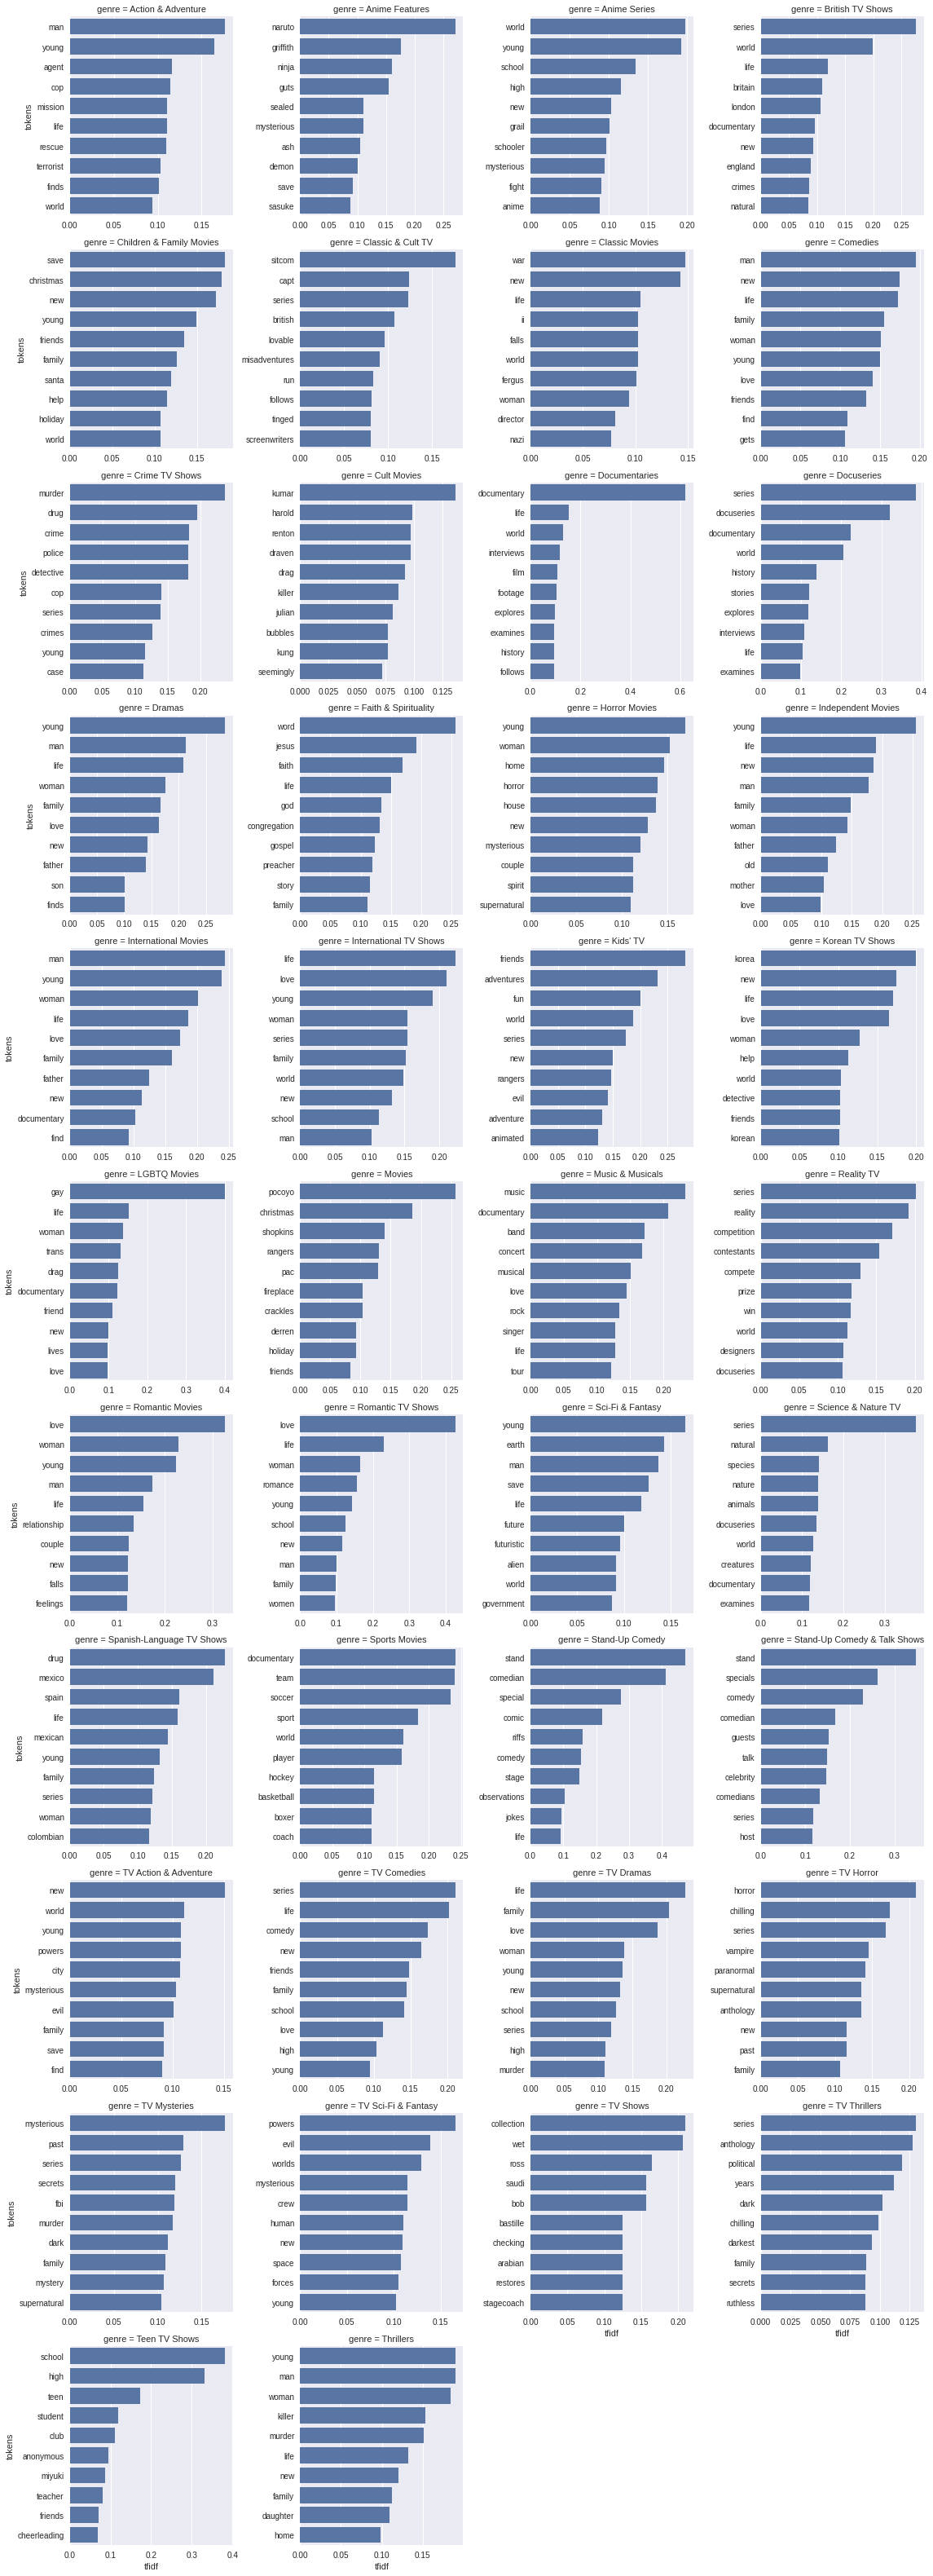

In [25]:
g = sns.FacetGrid(data=data_tokens_description_tfidf, col='genre', col_wrap=4, sharex=False, sharey=False, height=4)
g.map(sns.barplot,'tfidf','tokens')
plt.show()

In [26]:
spacy.__version__

'2.2.4'